# Introdução

## Importando as bibliotecas

In [1]:
import sys
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
from torch.utils.data import DataLoader
import sklearn
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
import seaborn as sns
import holidays
from src.model import VAE
from src.dataset import TSDataset


plt.style.use('tableau-colorblind10')

In [2]:
print('Python version:', sys.version)
print('Package versions:')
print('Pytorch:', torch.__version__)
print('Pytorch-Lightning:', pl.__version__)
print('Matplotlib:', matplotlib.__version__)
print('scikit-learn:', sklearn.__version__)
print('Weights&Biases:', wandb.__version__)

Python version: 3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Package versions:
Pytorch: 2.4.1+cu124
Pytorch-Lightning: 2.4.0
Matplotlib: 3.9.2
scikit-learn: 1.5.2
Weights&Biases: 0.18.3


## Carregando os dados

In [3]:
name = 'machine_temperature_system_failure'

In [4]:
raw_dt = pd.read_csv(f"./dataset/realKnownCause/{name}.csv")
raw_dt.head(5)

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [5]:
raw_dt.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


Text(0.5, 1.0, 'Original Dataset')

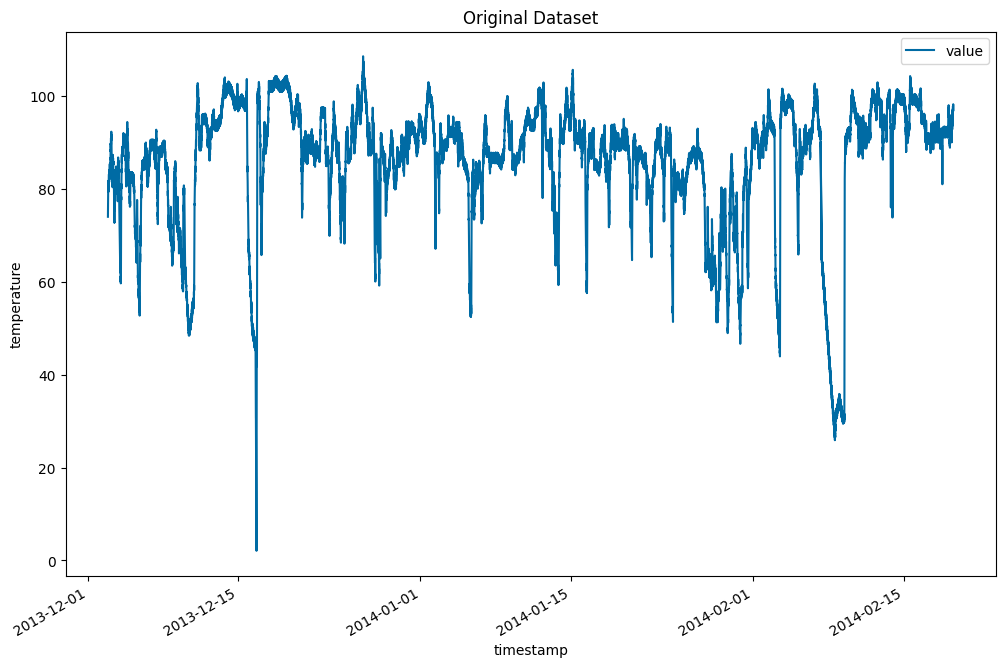

In [6]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset")

In [7]:
raw_dt['timestamp'] = pd.to_datetime(raw_dt['timestamp'])

In [8]:
print('Start time: ', raw_dt["timestamp"].min())
print('End time: ', raw_dt["timestamp"].max())
print('Time difference: ', raw_dt["timestamp"].max()-raw_dt["timestamp"].min())

Start time:  2013-12-02 21:15:00
End time:  2014-02-19 15:25:00
Time difference:  78 days 18:10:00


## Visualizando os dados

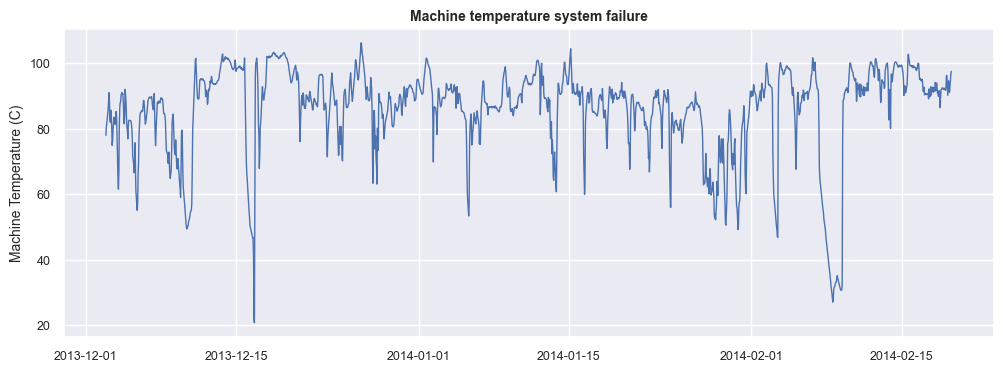

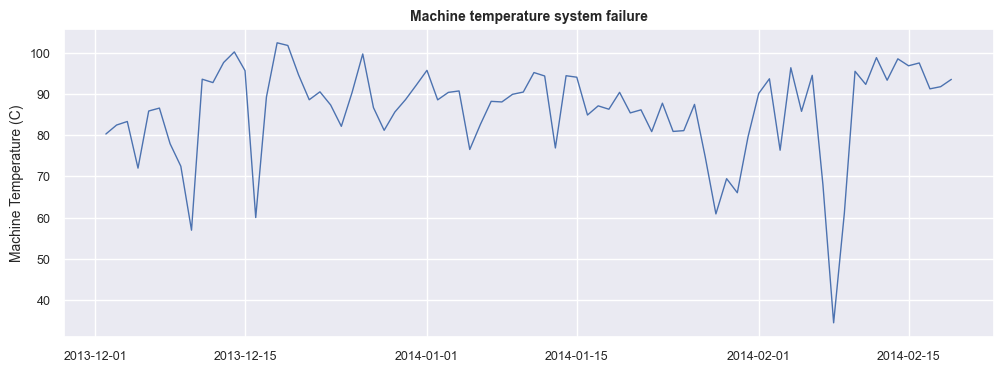

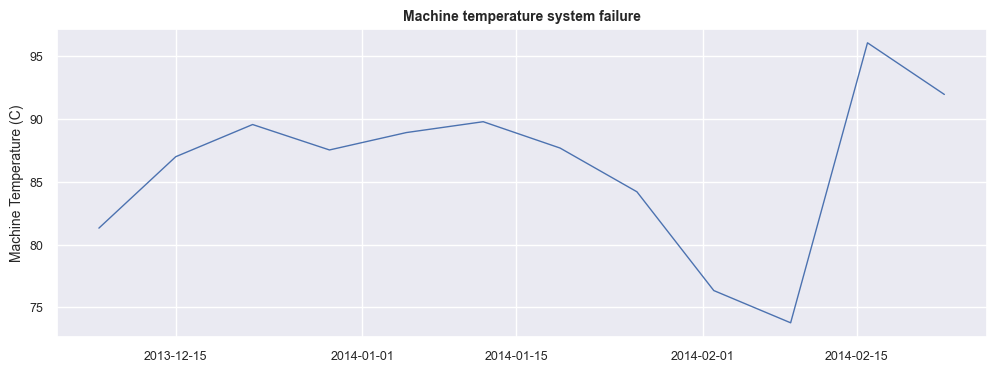

In [9]:
sns.set(rc={'figure.figsize':(12, 4)})
raw_dt.set_index('timestamp', inplace=True)
titulo = 'Machine temperature system failure'
ylabel = 'Machine Temperature (C)'
fig1, ax1 = plt.subplots()
sns.lineplot(data=raw_dt.resample('h').mean(), ax=ax1, x="timestamp", y="value", linewidth=1)
ax1.axes.set_title(titulo,fontsize=10, weight='bold')
ax1.set_xlabel("",fontsize=10)
ax1.set_ylabel(ylabel,fontsize=10)
ax1.tick_params(labelsize=9)
plt.legend([],[], frameon=False)

fig2, ax2 = plt.subplots()
sns.lineplot(data=raw_dt.resample('D').mean(), ax=ax2, x="timestamp", y="value", linewidth=1)
ax2.axes.set_title(titulo,fontsize=10, weight='bold')
ax2.set_xlabel("",fontsize=10)
ax2.set_ylabel(ylabel,fontsize=10)
ax2.tick_params(labelsize=9)
plt.legend([],[], frameon=False)

fig3, ax3 = plt.subplots()
sns.lineplot(data=raw_dt.resample('W').mean(), ax=ax3, x="timestamp", y="value", linewidth=1)
ax3.axes.set_title(titulo,fontsize=10, weight='bold')
ax3.set_xlabel("",fontsize=10)
ax3.set_ylabel(ylabel,fontsize=10)
ax3.tick_params(labelsize=9)
plt.legend([],[], frameon=False)

plt.show()

## Tratando os dados

In [10]:
us_holidays = holidays.US()


data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = data['timestamp'].map(lambda x: 1 if x in us_holidays else 0)

In [11]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1),
       datetime.date(2014, 1, 20), datetime.date(2014, 2, 17)],
      dtype=object)

In [12]:
last_holiday = min(data[data['holiday']==1]["timestamp"])
for e, row in data.iterrows():
    if row['holiday']==1:
        last_holiday = row["timestamp"]
    data.at[e, 'gap_holiday'] = row["timestamp"] - last_holiday

In [13]:
data.head()

,timestamp,value,day,month,hour_min,day_of_week,holiday,gap_holiday
0,2013-12-02 21:15:00,73.967322,2,12,21.250000,0,0,-23 days +21:15:00
1,2013-12-02 21:20:00,74.935882,2,12,21.333333,0,0,-23 days +21:20:00
2,2013-12-02 21:25:00,76.124162,2,12,21.416667,0,0,-23 days +21:25:00
3,2013-12-02 21:30:00,78.140707,2,12,21.500000,0,0,-23 days +21:30:00
4,2013-12-02 21:35:00,79.329836,2,12,21.583333,0,0,-23 days +21:35:00


In [14]:
data['gap_holiday'] = data['gap_holiday'].astype('timedelta64[s]')
data['gap_holiday'] = data['gap_holiday'] / np.timedelta64(1, 'D')

In [15]:
data['gap_holiday'] 

0       -22.114583
1       -22.111111
2       -22.107639
3       -22.104167
4       -22.100694
           ...    
22690     1.631944
22691     1.635417
22692     1.638889
22693     1.642361
22694     1.645833
Name: gap_holiday, Length: 22695, dtype: float64

In [16]:
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,2,12,21.250000,0,0,-22.114583,13860189
1,74.935882,2,12,21.333333,0,0,-22.111111,13860192
2,76.124162,2,12,21.416667,0,0,-22.107639,13860195
3,78.140707,2,12,21.500000,0,0,-22.104167,13860198
4,79.329836,2,12,21.583333,0,0,-22.100694,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,19,2,15.083333,2,0,1.631944,13928223
22691,97.804168,19,2,15.166667,2,0,1.635417,13928226
22692,97.135468,19,2,15.250000,2,0,1.638889,13928229
22693,98.056852,19,2,15.333333,2,0,1.642361,13928232


In [17]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,21.250000,0,0,-22.114583,13860189
1,74.935882,1,2,21.333333,0,0,-22.111111,13860192
2,76.124162,1,2,21.416667,0,0,-22.107639,13860195
3,78.140707,1,2,21.500000,0,0,-22.104167,13860198
4,79.329836,1,2,21.583333,0,0,-22.100694,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,18,1,15.083333,2,0,1.631944,13928223
22691,97.804168,18,1,15.166667,2,0,1.635417,13928226
22692,97.135468,18,1,15.250000,2,0,1.638889,13928229
22693,98.056852,18,1,15.333333,2,0,1.642361,13928232


## Modelando os dados para treinamento

In [19]:
test_ratio = 0.3

In [20]:
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [21]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [22]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [23]:
tr_data, tr_data_scaled

(           value  day  month   hour_min  day_of_week  holiday  gap_holiday  \
 0      73.967322    1      2  21.250000            0        0   -22.114583   
 1      74.935882    1      2  21.333333            0        0   -22.111111   
 2      76.124162    1      2  21.416667            0        0   -22.107639   
 3      78.140707    1      2  21.500000            0        0   -22.104167   
 4      79.329836    1      2  21.583333            0        0   -22.100694   
 ...          ...  ...    ...        ...          ...      ...          ...   
 15881  88.470506   25      0  23.666667            6        0     5.989583   
 15882  88.395883   25      0  23.750000            6        0     5.993056   
 15883  88.608302   25      0  23.833333            6        0     5.996528   
 15884  87.756352   25      0  23.916667            6        0     6.000000   
 15885  88.236311   26      0   0.000000            0        0     6.003472   
 
               t  
 0      13860189  
 1      1386

In [24]:
tr_data_scaled.to_csv('./dataset/train.csv', index=False)
tst_data_scaled.to_csv('./dataset/test.csv', index=False)

In [25]:
ds = TSDataset(split='both', cont_vars=['value', 't'], cat_vars=['day_of_week', 'holiday'], lbl_as_feat=True)
print(len(ds))
it = iter(ds)
for _ in range(10):
    print(next(it))

22695
(tensor([-1.2244, -1.7328]), tensor([0, 0]))
(tensor([-1.1341, -1.7326]), tensor([0, 0]))
(tensor([-1.0234, -1.7324]), tensor([0, 0]))
(tensor([-0.8355, -1.7322]), tensor([0, 0]))
(tensor([-0.7247, -1.7319]), tensor([0, 0]))
(tensor([-0.7824, -1.7317]), tensor([0, 0]))
(tensor([-0.6371, -1.7315]), tensor([0, 0]))
(tensor([-0.6368, -1.7313]), tensor([0, 0]))
(tensor([-0.6293, -1.7311]), tensor([0, 0]))
(tensor([-0.7101, -1.7308]), tensor([0, 0]))


In [26]:
cont_features = ['value', 'hour_min', 'gap_holiday', 't'] 
cat_features = ['day_of_week', 'holiday']  # Remember that we removed `day` and `month`

embed_cats = [len(tr_data_scaled[c].unique()) for c in cat_features]

hparams = OrderedDict(
    run='VAE_' + name,
    cont_vars = cont_features,
    cat_vars = cat_features,
    embedding_sizes = [(embed_cats[i], 16) for i in range(len(embed_cats))],
    latent_dim = 16,
    layer_sizes = '64,128,256,128,64',
    batch_norm = True,
    stdev = 0.1,
    kld_beta = 0.05,
    lr = 0.001,
    weight_decay = 1e-5,
    batch_size = 128,
    epochs = 60,
)

In [36]:
dataset_train = TSDataset('train', cont_vars=cont_features, 
            cat_vars = cat_features, lbl_as_feat=True
        )
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2
)

In [28]:
dataset_test = TSDataset('test', cont_vars=cont_features,
            cat_vars=cat_features, lbl_as_feat=True
        )
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True
)

In [29]:
hparams

OrderedDict([('run', 'VAE_machine_temperature_system_failure'),
             ('cont_vars', ['value', 'hour_min', 'gap_holiday', 't']),
             ('cat_vars', ['day_of_week', 'holiday']),
             ('embedding_sizes', [(7, 16), (2, 16)]),
             ('latent_dim', 16),
             ('layer_sizes', '64,128,256,128,64'),
             ('batch_norm', True),
             ('stdev', 0.1),
             ('kld_beta', 0.05),
             ('lr', 0.001),
             ('weight_decay', 1e-05),
             ('batch_size', 128),
             ('epochs', 60)])

In [30]:
torch.set_float32_matmul_precision('medium')

In [31]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [32]:
model = VAE(**hparams)
logger = WandbLogger(name=hparams['run'], project='VAE_Anomaly', version=hparams['run'])
ckpt_callback = pl.callbacks.ModelCheckpoint(dirpath='.', filename='vae_weights')
# Replace argument logger by None if you don't have a WandB account (and don't want to create one)
trainer = pl.Trainer(accelerator='gpu', devices=1, strategy='auto', logger=logger, 
                     max_epochs=hparams['epochs'], benchmark=True,
                     callbacks=[ckpt_callback], gradient_clip_val=10., enable_model_summary=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(model, train_dataloaders=data_loader_train)

f:\XP\Notebooks\Modulo 03 - Generative IA\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory F:\XP\Notebooks\Modulo 03 - Generative IA\aula_interativa exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 88.4 K | train
1 | decoder | Decoder | 87.2 K | train
--------------------------------------------
175 K     Trainable params
0         Non-trainable params
175 K     Total params
0.702     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode
f:\XP\Notebooks\Modulo 03 - Generative IA\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Configuring optimizers
Optimizers configured
Epoch 24:   0%|          | 0/125 [00:00<?, ?it/s, v_num=lure, total_loss=0.0202, recon_loss=0.0181, kld=0.042]             


Detected KeyboardInterrupt, attempting graceful shutdown ...
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000207357476A0>
Traceback (most recent call last):
  File "f:\XP\Notebooks\Modulo 03 - Generative IA\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "f:\XP\Notebooks\Modulo 03 - Generative IA\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


NameError: name 'exit' is not defined

In [38]:
trainer.test(model, dataloaders=data_loader_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
f:\XP\Notebooks\Modulo 03 - Generative IA\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
f:\XP\Notebooks\Modulo 03 - Generative IA\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 54/54 [00:00<00:00, 152.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03117087483406067    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03117087483406067}]

In [39]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
kld,█▆▅▄▄▃▃▄▃▃▃▃▄▃▂▃▂▃▃▂▂▃▂▂▂▂▂▄▂▂▂▂▂▁▂▂▂▂▁▂
recon_loss,▆▂▄▂▂▁█▁▁▁▁▁▁▁▅▁▁▁▃▁▆▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂
test_loss,▁
total_loss,▆▃▂▂▄▂█▁▁▁▁▁▁▅▁▁▃▁▁▁▆▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,24
kld,0.04198
recon_loss,0.01807
test_loss,0.03117
total_loss,0.02017


In [41]:
dataset = TSDataset('test', cont_vars=hparams['cont_vars'],
                    cat_vars=['day_of_week', 'holiday'],
                    lbl_as_feat=True) 

trained_model = VAE.load_from_checkpoint('./vae_weights.ckpt')
trained_model.freeze()
trained_model.to(device)
losses = []
# run predictions for the training set examples
for i in range(len(dataset)):
    x_cont, x_cat = dataset[i]
    x_cont = x_cont.unsqueeze_(0).to(trained_model.device)
    x_cat = x_cat.unsqueeze_(0).to(trained_model.device)
    recon, mu, logvar, x = trained_model.forward((x_cont, x_cat))
    recon_loss, kld = trained_model.loss_function(x, recon, mu, logvar)
    losses.append(recon_loss.cpu() + trained_model.hparams.kld_beta * kld.cpu())
    
data_with_losses = dataset.df
data_with_losses['loss'] = np.asarray(losses)
data_with_losses.sort_values('t', inplace=True)
data_with_losses.head()

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t,loss
0,0.128276,26,0,-1.712961,0,0,0.676009,1.732299,0.015771
1,-0.038872,26,0,-1.700954,0,0,0.676352,1.732517,0.015530
2,0.088313,26,0,-1.688948,0,0,0.676695,1.732736,0.015680
3,0.124557,26,0,-1.676941,0,0,0.677038,1.732954,0.015721
4,0.014094,26,0,-1.664935,0,0,0.677381,1.733172,0.015597


In [42]:
mean, sigma = data_with_losses['loss'].mean(), data_with_losses['loss'].std()
mean, sigma

(0.031178674, 0.017799653)

In [43]:
quant = 0.999
thresh = data_with_losses['loss'].quantile(quant)  # threshold for anomaly (quantile).
thresh

0.09756867980957032

In [44]:

data_with_losses['anomaly'] = data_with_losses['loss'] > thresh
print(data_with_losses.head())

      value  day  month  hour_min  day_of_week  holiday  gap_holiday  \
0  0.128276   26      0 -1.712961            0        0     0.676009   
1 -0.038872   26      0 -1.700954            0        0     0.676352   
2  0.088313   26      0 -1.688948            0        0     0.676695   
3  0.124557   26      0 -1.676941            0        0     0.677038   
4  0.014094   26      0 -1.664935            0        0     0.677381   

          t      loss  anomaly  
0  1.732299  0.015771    False  
1  1.732517  0.015530    False  
2  1.732736  0.015680    False  
3  1.732954  0.015721    False  
4  1.733172  0.015597    False  


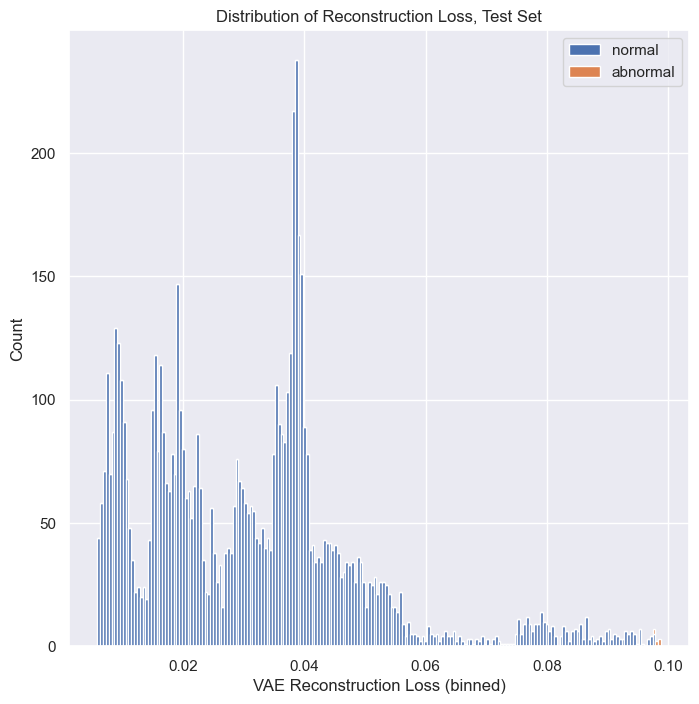

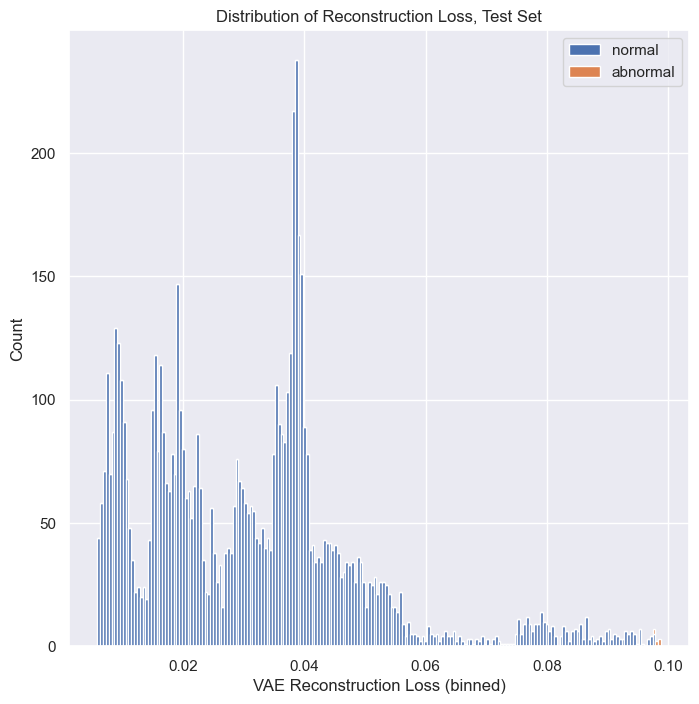

In [45]:
plt.figure(figsize=(8, 8))
anomalies_loss = data_with_losses.loc[data_with_losses['anomaly'], 'loss']
normals_loss   = data_with_losses.loc[~data_with_losses['anomaly'], 'loss']
plt.hist([normals_loss, anomalies_loss], bins=200, stacked=True, label=['normal', 'abnormal'])
plt.title("Distribution of Reconstruction Loss, Test Set")
plt.xlabel("VAE Reconstruction Loss (binned)")
plt.ylabel("Count")
plt.legend();plt.figure(figsize=(8, 8))
anomalies_loss = data_with_losses.loc[data_with_losses['anomaly'], 'loss']
normals_loss   = data_with_losses.loc[~data_with_losses['anomaly'], 'loss']
plt.hist([normals_loss, anomalies_loss], bins=200, stacked=True, label=['normal', 'abnormal'])
plt.title("Distribution of Reconstruction Loss, Test Set")
plt.xlabel("VAE Reconstruction Loss (binned)")
plt.ylabel("Count")
plt.legend()

In [46]:


data_with_losses_unscaled = data_with_losses.copy()
data_with_losses_unscaled[cont_vars] = scaler.inverse_transform(data_with_losses[cont_vars])
for enc, var in zip(label_encoders, cat_vars):
    data_with_losses_unscaled[var] = enc.inverse_transform(data_with_losses[var])
data_with_losses_unscaled = pd.DataFrame(data_with_losses_unscaled, columns=data_with_losses.columns)
data_with_losses_unscaled['timestamp'] = pd.to_datetime(data_with_losses_unscaled['t'] * 1e11, unit='ns')

print(data_with_losses_unscaled.head())



       value  day  month  hour_min  day_of_week  holiday  gap_holiday  \
0  88.482330   27      1  0.083333            0        0     6.006944   
1  86.688731   27      1  0.166667            0        0     6.010417   
2  88.053503   27      1  0.250000            0        0     6.013889   
3  88.442419   27      1  0.333333            0        0     6.017361   
4  87.257083   27      1  0.416667            0        0     6.020833   

            t      loss  anomaly           timestamp  
0  13907811.0  0.015771    False 2014-01-27 00:05:00  
1  13907814.0  0.015530    False 2014-01-27 00:10:00  
2  13907817.0  0.015680    False 2014-01-27 00:15:00  
3  13907820.0  0.015721    False 2014-01-27 00:20:00  
4  13907823.0  0.015597    False 2014-01-27 00:25:00  


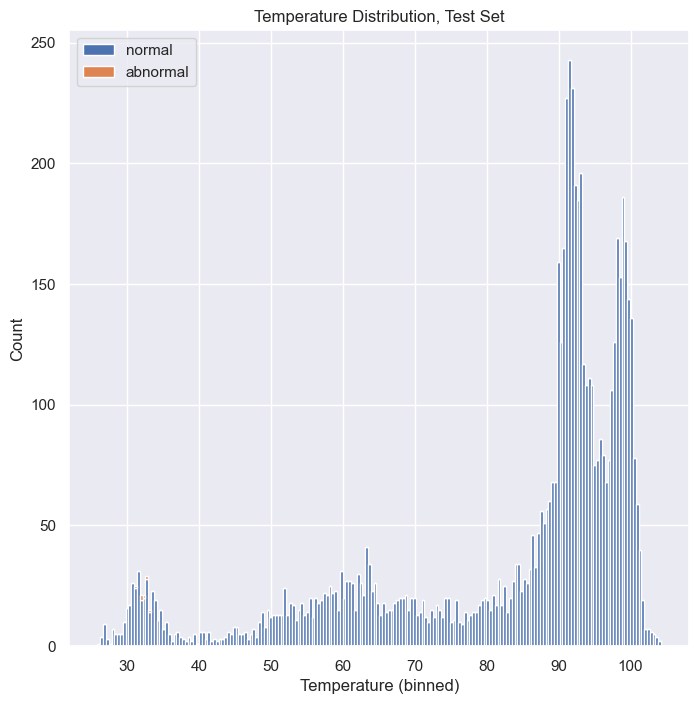

In [47]:
anomalies_value = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ['loss','value']]
normals_value = data_with_losses_unscaled.loc[~data_with_losses_unscaled['anomaly'], ['loss','value']]
plt.figure(figsize=(8,8))
plt.hist([normals_value['value'], anomalies_value['value']], bins=200, stacked=True, label=['normal', 'abnormal'])
plt.title("Temperature Distribution, Test Set")
plt.xlabel("Temperature (binned)")
plt.ylabel("Count")
plt.legend()

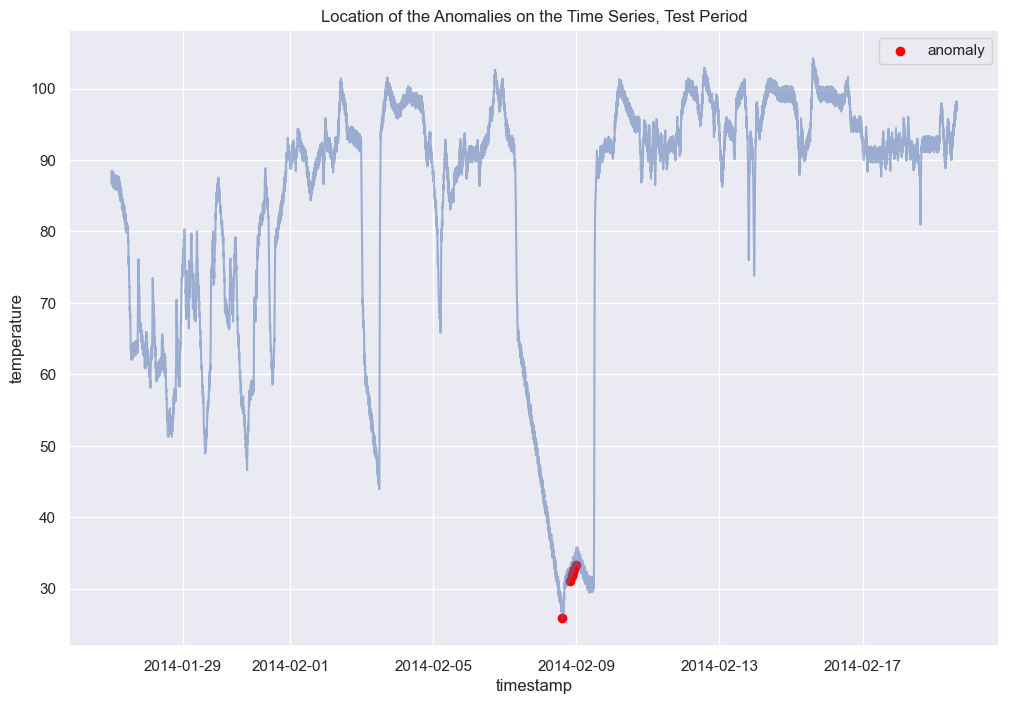

In [48]:
anomalies_ts = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_with_losses_unscaled['timestamp'], data_with_losses_unscaled['value'], alpha=.5)
ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period");